In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/onlineretail/OnlineRetail.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
# Load the dataset
url = "https://github.com/your-repo/online-retail/raw/main/OnlineRetail.csv"  # Replace with the actual dataset link
df = pd.read_csv('/kaggle/input/onlineretail/OnlineRetail.csv',encoding='latin1')

# Display the first few rows
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [4]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove negative quantities and prices (returns/cancellations)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# Create a TotalSpend column
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [5]:
# Aggregate customer-level features
customer_data = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',  # Number of transactions
    'TotalSpend': 'sum',     # Total spend
    'Quantity': 'sum',       # Total items purchased
    'InvoiceDate': ['min', 'max']  # First and last purchase dates
}).reset_index()

# Flatten the multi-level column index
customer_data.columns = ['CustomerID', 'NumTransactions', 'TotalSpend', 'TotalQuantity', 'FirstPurchaseDate', 'LastPurchaseDate']

# Calculate customer lifetime (in days)
customer_data['CustomerLifetime'] = (customer_data['LastPurchaseDate'] - customer_data['FirstPurchaseDate']).dt.days

# Define high-value customers (top 20% by TotalSpend)
customer_data['HighValue'] = (customer_data['TotalSpend'] > customer_data['TotalSpend'].quantile(0.8)).astype(int)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


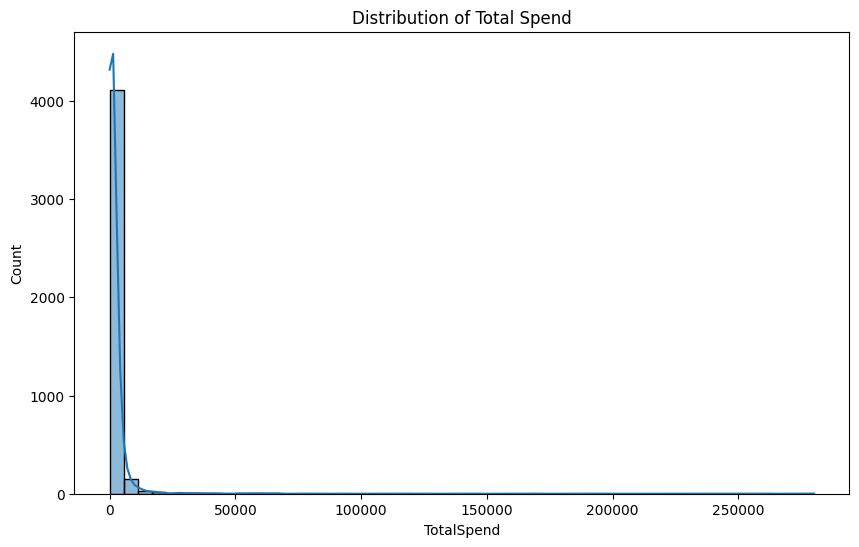

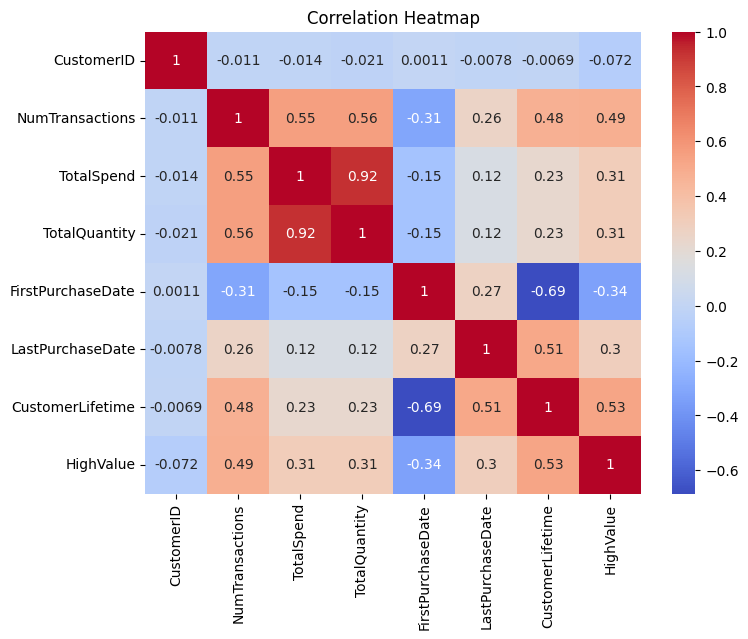

In [6]:
# Distribution of TotalSpend
plt.figure(figsize=(10, 6))
sns.histplot(customer_data['TotalSpend'], bins=50, kde=True)
plt.title('Distribution of Total Spend')
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(customer_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [7]:
# Drop date columns (not needed for modeling)
customer_data = customer_data.drop(['FirstPurchaseDate', 'LastPurchaseDate'], axis=1)

# Encode CustomerID (if needed)
le = LabelEncoder()
customer_data['CustomerID'] = le.fit_transform(customer_data['CustomerID'])

# Split features and target
X = customer_data.drop(['HighValue'], axis=1)
y = customer_data['HighValue']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# Train a RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       691
           1       1.00      0.99      1.00       177

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868



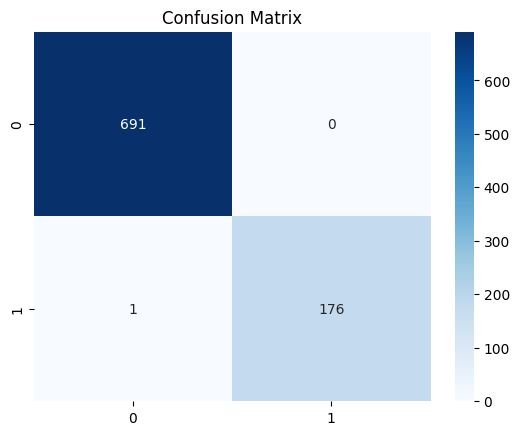

ROC-AUC Score: 1.0


In [9]:
# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC Score: {roc_auc}')

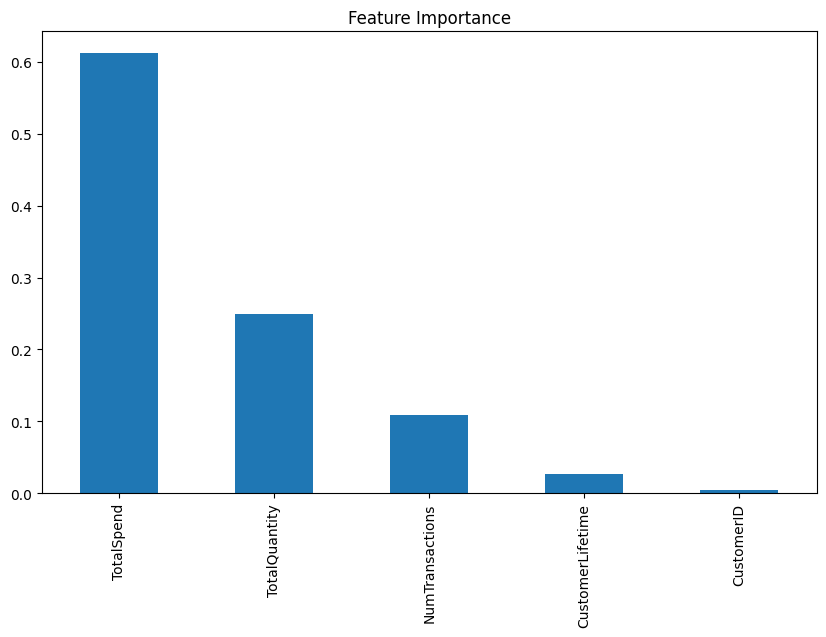

In [10]:
# Plot feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importance')
plt.show()

In [11]:
# Segment customers based on TotalSpend
customer_data['Segment'] = pd.cut(
    customer_data['TotalSpend'],
    bins=[-1, 100, 500, float('inf')],
    labels=['Low-Value', 'Medium-Value', 'High-Value']
)

# Save segmented data to CSV
customer_data[['CustomerID', 'Segment']].to_csv('customer_segments.csv', index=False)

In [12]:
# Calculate CLV (simplified formula: Average Purchase Value * Purchase Frequency * Customer Lifespan)
avg_purchase_value = customer_data['TotalSpend'] / customer_data['NumTransactions']
purchase_frequency = customer_data['NumTransactions'] / customer_data['CustomerLifetime']
customer_lifespan = customer_data['CustomerLifetime']
customer_data['CLV'] = avg_purchase_value * purchase_frequency * customer_lifespan

# Save CLV data to CSV
customer_data[['CustomerID', 'CLV']].to_csv('customer_clv.csv', index=False)

In [13]:
# Simulate A/B test data
np.random.seed(42)
customer_data['TestGroup'] = np.random.choice(['A', 'B'], size=len(customer_data))

# Save A/B test data to CSV
customer_data[['CustomerID', 'TestGroup']].to_csv('ab_test_groups.csv', index=False)

In [14]:
# Define dynamic pricing rules (example: discount for high-value customers)
customer_data['DynamicPrice'] = np.where(
    customer_data['HighValue'] == 1,
    customer_data['TotalSpend'] * 0.9,  # 10% discount for high-value customers
    customer_data['TotalSpend']
)

# Save dynamic pricing data to CSV
customer_data[['CustomerID', 'DynamicPrice']].to_csv('dynamic_pricing.csv', index=False)

In [15]:
# Identify top-rated products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

# Save top products to CSV
top_products.to_csv('top_products.csv', index=True)